## Desenvolvendo um Fluxo no Notebook

### Carregar variáveis

In [1]:
from dotenv import load_dotenv
load_dotenv()

False

### Criando o chatbot

In [ ]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]



In [ ]:
# modelo
import os
from langchain.chat_models import init_chat_model
llm = init_chat_model("openai:gpt-4o-mini")

In [13]:
# chatbot
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

graph_builder = StateGraph(State)

# adiciona nós
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# compilando
graph = graph_builder.compile()

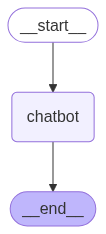

In [14]:
graph

### Executando

In [15]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: Olá! Tudo bem, e você? Como posso ajudá-lo hoje?
Goodbye!


### V2 - customizado

In [ ]:
from utils import *
from variables import *

from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.chat_models import init_chat_model
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable
from variables import *
import os

class State(TypedDict):
    messages: Annotated[list, add_messages]

# --- 1. Define the Prompt Template ---
# This gives our agent its personality and instructions.
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful AI assistant. Your name is Codium. Respond in a friendly and clear manner.",
        ),
        ("placeholder", "{messages}"),
    ]
)

# --- Language Model ---
llm = init_chat_model("openai:gpt-4o-mini")

# --- 2. Create the Agent Node ---
# This node will format the prompt and call the model.
def agent_node(state: State):
    """
    Invokes the agent with the current state to generate a response.
    """
    # The chain combines the prompt and the model
    chain: Runnable = prompt | llm
    
    # We pass the entire message history to the chain
    response = chain.invoke({"messages": state["messages"]})
    
    # The result is a new message that we add to the state
    return {"messages": [response]}

# --- 3. Build the Graph ---
graph_builder = StateGraph(State)

# Add our new agent node
graph_builder.add_node("agent", agent_node)
graph_builder.add_edge(START, "agent")
graph_builder.add_edge("agent", END)

# Compile the graph
memory = InMemorySaver()
graph = graph_builder.compile(checkpointer=memory)

print('Graph with custom agent node compiled successfully.')


Graph with custom agent node compiled successfully.


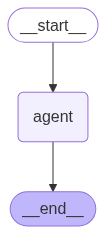

In [2]:
graph